In [1]:
import numpy as np
import scipy
import seaborn as sns
import math
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
import pyhilbert as hil
import pyredmod as rm

%matplotlib inline

## First we check our FEM solution against a known analytic solution
Here we solve the problem $$-\nabla \cdot (a(x) \nabla u(x)) = f(x)$$ using FEM, where $a(x)=1$ is constant, with  homogeneous Dirichlet bdry conditions and $f(x) = 1$. This is the Poisson equation and has a known analytic solution, which we check our solution against. 

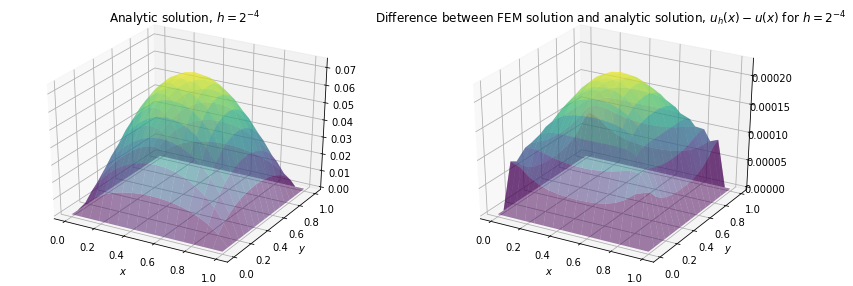

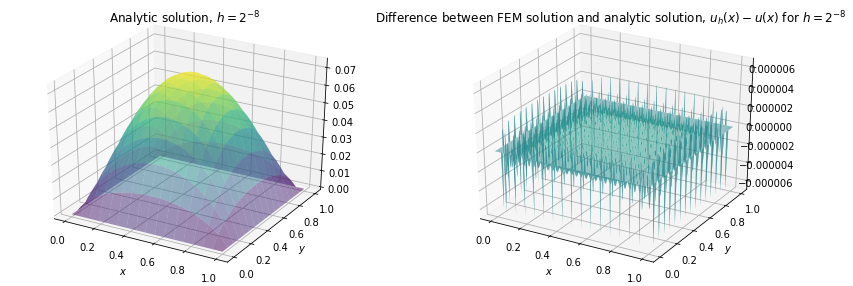

In [2]:
field_div = 1

H1_spaces = [hil.H1DyadicSq(div) for div in [4, 6, 8]]
L2_coarse = hil.L2DyadicSq(0)
constant_field = hil.Vector(np.ones(1), space=L2_coarse)

def analytic_soln(x,y,N=32,M=32):
    # This is the standard series solution for the Poisson problem on the unit square 
    # with homogeneous dirichelet boundaries and uniform force f=1
    soln = np.zeros(x.shape)
    for i in range(N):
        for j in range(M):
            n = 2*i+1
            m = 2*j+1
            soln = soln + (16.0 / (math.pi*math.pi*math.pi*math.pi)) * (1.0/(n*m*(n*n + m*m))) * \
                    np.sin(n*math.pi*x) * np.sin(m*math.pi*y)
    return soln

for H1 in H1_spaces:
    fem_solver = hil.DyadicFEMSolver(fem_space=H1, rand_field=constant_field, f=1)
    fem_solver.solve()
    u = fem_solver.u
    
    analytic = hil.Vector.from_func(func=analytic_soln, space=H1)

    # Now just plot the difference between the analytic solution and the FEM solution
    fig = plt.figure(figsize=(14, 5))

    ax = fig.add_subplot(1, 2, 1, projection='3d')
    (analytic).plot(ax, title=rf'Analytic solution, $h=2^{{{-H1.div}}}$')

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    (analytic - u).plot(ax2, title=rf'Difference between FEM solution and analytic solution, $u_h(x) - u(x)$ for $h=2^{{{-H1.div}}}$')

    plt.show()

We see that the FEM solution on the $2^8$ subdivided square (RHS above) has converged closer to the analytic solution than the $2^4$ subdivided square (LHS above).

# We trust our FEM solution is correct, now we try arbitrary dyadic fields

Here we solve the problem $$-\nabla \cdot (a(x) \nabla u(x)) = f(x)$$ using FEM,where $a(x)$ is a randomly generated piecewise constant function on the dyadic subdivision of the unit square. The field is given by 
$$ a(x) = \bar{a} + c \sum_i y_i \mathbb{1}_{s_i}(x) $$
where $\bar{a}$ and $c$ are constants (given below), $y_i$ is a uniform RV from $[-1,1]$, and $\mathbb{1}_{s_i}$ is the indicator function on the $i$-th dyadic square $s_i$.

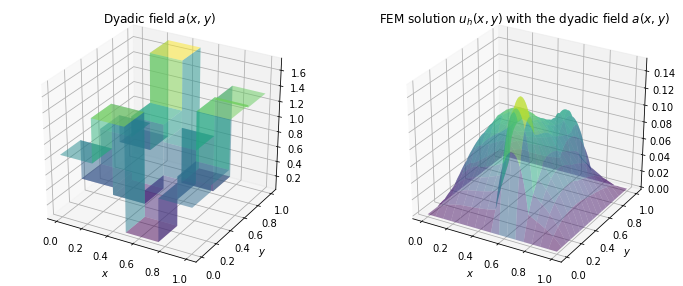

In [3]:
np.random.seed(1)
H1_fine = hil.H1DyadicSq(8)
L2_coarse = hil.L2DyadicSq(2)

a_bar = 1
c = 0.95
y = 2 * np.random.random((4,4)) - 1
a = hil.Vector(a_bar + c * y.flatten(), space=L2_coarse)

fem_solver = hil.DyadicFEMSolver(fem_space=H1, rand_field=a, f=1)
fem_solver.solve()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
a.plot(ax, title='Dyadic field $a(x,y)$')
ax = fig.add_subplot(1, 2, 2, projection='3d')
fem_solver.u.plot(ax, title='FEM solution $u_h(x,y)$ with the dyadic field $a(x,y)$')
plt.show()

## Test L2 and H1 inner product routines in DyadicPWLinear
We test the $L^2$ and $H^1_0$ norms for functions in $U_h$ (our dyadic triangulation subspace), for a test function $f(x,y) = \sin(\pi x) \sin(\pi y)$, that has known analytic values of $\| f \|_{L^2} = 1/4$ and $\| f \|_{H^1_0} = \pi^2 / 2 + 1/4$

We also test $\langle f, g \rangle_{H_0^1}$ for $f=\sin(\pi x) \sin(\pi y)$ and $g(x,y)=x(1-x)y(1-y)$, which should get us $\langle f, g \rangle_{L^2} = 16 / \pi^6$ and $\langle f, g \rangle_{H_0^1} = 16 / \pi^6 + 32 / \pi^4$

In [4]:
print('Testing convergence of L2 norm to analytic soln of 0.25 \n \
and H1 norm to pi^2 / 2, for increasing dyadic subdiv')

# We define the function we want to creat pw linear approx of...
def f(x,y): return np.sin(math.pi*x) * np.sin(math.pi*y)

for div in range(2,12,2):
    # This will create an interpolated pw-linear function on the dyadic grid of subdivision div
    u_H1 = hil.Vector.from_func(func=f, space=hil.H1DyadicSq(div))
    u_L2 = hil.Vector.from_func(func=f, space=hil.L2DyadicSq(div))
    print(f'Dyadic level {div}, \tL2: {u_L2.dot(u_L2):0.8e}, \tH1_0: {u_H1.dot(u_H1):0.8e}')
    # NB the L2 norm should be close to (u.values * u.values).sum() / ((2**div+1) * (2**div+1)),

print(f'Analytic \t\tL2: {0.25:0.8e}, \tH1_0: {math.pi * math.pi / 2.0:0.8e}')

# Ok - we do a few more tests to convince ourselves.

print('\nTesting convergence of L2 dot prod to analytic soln of (4/pi^3)^2 \n \
and H1 norm to (4/pi^3)^2 + (32/pi^4), for increasing dyadic subdiv')
# lets try g(x,y) = x * y
def g(x,y): return x * (1-x) * y * (1-y)

print
for div in range(2,12,2):
    # This will create an interpolated pw-linear function on the dyadic grid of subdivision div
    u_H1 = hil.Vector.from_func(func=f, space=hil.H1DyadicSq(div))
    u_L2 = hil.Vector.from_func(func=f, space=hil.L2DyadicSq(div))
    v_H1 = hil.Vector.from_func(func=g, space=hil.H1DyadicSq(div))
    v_L2 = hil.Vector.from_func(func=g, space=hil.L2DyadicSq(div))
    print(f'Dyadic level {div}, \tL2: {u_L2.dot(v_L2):0.8e}, \tH1_0: {u_H1.dot(v_H1):0.8e}')
    # NB the L2 norm should be close to (u.values * u.values).sum() / ((2**div+1) * (2**div+1)),

print(f'Analytic \t\tL2: {16.0 /(math.pi**6):0.8e}, \tH1_0: {32.0/(math.pi**4):0.8e}')


Testing convergence of L2 norm to analytic soln of 0.25 
 and H1 norm to pi^2 / 2, for increasing dyadic subdiv
Dyadic level 2, 	L2: 2.50000000e-01, 	H1_0: 4.68629150e+00
Dyadic level 4, 	L2: 2.50000000e-01, 	H1_0: 4.91896822e+00
Dyadic level 6, 	L2: 2.50000000e-01, 	H1_0: 4.93381138e+00
Dyadic level 8, 	L2: 2.50000000e-01, 	H1_0: 4.93474027e+00
Dyadic level 10, 	L2: 2.50000000e-01, 	H1_0: 4.93479833e+00
Analytic 		L2: 2.50000000e-01, 	H1_0: 4.93480220e+00

Testing convergence of L2 dot prod to analytic soln of (4/pi^3)^2 
 and H1 norm to (4/pi^3)^2 + (32/pi^4), for increasing dyadic subdiv
Dyadic level 2, 	L2: 1.66913824e-02, 	H1_0: 3.10929608e-01
Dyadic level 4, 	L2: 1.66427646e-02, 	H1_0: 3.27453290e-01
Dyadic level 6, 	L2: 1.66425843e-02, 	H1_0: 3.28445457e-01
Dyadic level 8, 	L2: 1.66425836e-02, 	H1_0: 3.28507309e-01
Dyadic level 10, 	L2: 1.66425836e-02, 	H1_0: 3.28511174e-01
Analytic 		L2: 1.66425836e-02, 	H1_0: 3.28511432e-01


## Now we look at coarse grid approximations, where $V_n$ is the space of $n$ coarse grid hat functions
This code computes an FEM solution $u_h$ from $a$. We have a full set of coarse grid hat functions $V_n = \{ v_1, v_2, \ldots, v_n\}$, i.e. $n = (2^d-1) \times (2^d - 1)$ where $d = \mathtt{coarse\_div}$, the dyadic level of the coarse grid, that is we have a hat function for every possible point in the grid that is not on the boundary. We compute the set of inner products $$w_i = \langle v_i, u_h \rangle$$ 
where the inner product is both the $L^2$ and $H^1_0$ inner product. $V_n$ is not orthonormal, so we must do some linear algebra...

We reconstruct the function by computing the matrix $\mathbf{\Phi}$, where $$\Phi_{i,j} = \langle v_i, v_j \rangle$$ and we then solve the system $$\mathbf{\Phi} \mathbf{y} = \mathbf{w}$$ where $\mathbf{w}$ is the vector with values $w_i$. We solve for $\mathbf{y}$, and our reconstruction is then $$\hat{u}_h(x) = \sum_{i=1}^n y_i v_i(x)$$ which we plot and look at the differences. This reconstruction should be $\hat{u}_h = P_{V_n} u_h$, where $P_{V_n}$ is the projection operator.

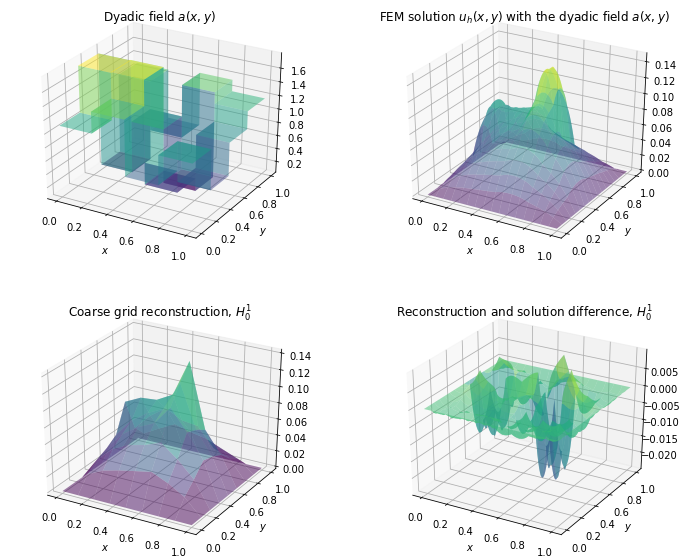

In [5]:
# The dyadic divisino levels for the random field, the FEM solution, and the
# approximate solution space v_n
H1_fine = hil.H1DyadicSq(7)
H1_coarse = hil.H1DyadicSq(3)
L2_coarse = hil.L2DyadicSq(2)

np.random.seed(3)
a_bar = 1
c = 0.99
y = 2 * np.random.random((4,4)) - 1
a = hil.Vector(a_bar + c * y.flatten(), space=L2_coarse)
fem_solver = hil.DyadicFEMSolver(fem_space=H1_fine, rand_field=a, f=1)
fem_solver.solve()

V_n = []
# n is the number of internal coarse grid points, i.e. we will have n different hat functionsdd
# for our coarse-grid basis
n = H1_coarse.n #(2**coarse_div-1) * (2**coarse_div-1)
side_n = H1_coarse.side_len #2**coarse_div-1

Phi_L2 = np.zeros([n, n])
Phi_H1 = np.zeros([n, n])
w_L2 = np.zeros(n)
w_H1 = np.zeros(n)
for k in range(side_n):
    for l in range(side_n):
        v_i = hil.Vector.zero(space=H1_coarse)
        v_i.values[k*side_n + l] = 1.0
        V_n.append(v_i)
        
        # Now we take the H1_0 dot product between this and the FEM soln
        w_H1[k*side_n + l] = fem_solver.u.dot(v_i)
        
        # And build the co-dependence matrix at the same time...
        for k2 in range(side_n):
            for l2 in range(side_n):
                v_j = hil.Vector.zero(space=H1_coarse)
                v_j.values[k2*side_n + l2] = 1.0

                Phi_H1[side_n * k + l, side_n * k2 + l2] = v_i.dot(v_j)

# Now we get the coefficients by solving the linear system (BTW We'll do this in the next section with Gram-Schmidt/
# QR factorisation... much easier and quicker...)
y_H1 = np.linalg.solve(Phi_H1, w_H1)

# We can put these values straight in to the pw linear function as our v_i are just hat functions...
u_hat_H1 = hil.Vector(values=y_H1, space=H1_coarse)

fig = plt.figure(figsize=(12, 10))

ax = fig.add_subplot(2, 2, 1, projection='3d')
a.plot(ax, title='Dyadic field $a(x,y)$')

ax = fig.add_subplot(2, 2, 2, projection='3d')
fem_solver.u.plot(ax, title='FEM solution $u_h(x,y)$ with the dyadic field $a(x,y)$')

ax = fig.add_subplot(2, 2, 3, projection='3d')
u_hat_H1.plot(ax, title='Coarse grid reconstruction, $H^1_0$')

ax = fig.add_subplot(2, 2, 4, projection='3d')
(u_hat_H1 - fem_solver.u).plot(ax, title='Reconstruction and solution difference, $H^1_0$')

plt.show()

## Now we do the same but by first constructing an orthonormal basis from our set $V_n$

The method here is a bit of a hack because there is no built in Gram-Schmidt operation in NumPy. We use the Cholesky factorisation followed by an upper triangular inversion to get us a quick and stable orthogonalisation of the basis functions.

I.e. if we have $\Phi_{i,j} = \langle \phi_i, \phi_j \rangle$, and we want to find $\tilde{\phi}_i(x) = \sum_j G_{i,j} \phi_j(x)$ such that $\tilde{\Phi}_{i,j} = \langle \tilde\phi_i, \tilde\phi_j \rangle = \delta_{i,j}$. This means that 
$$ \tilde{\Phi}_{i,j} = \left\langle\sum_k G_{i,k} \phi_k, \sum_\ell G_{j,\ell} \phi_\ell\right\rangle
= \sum_k \sum_\ell G_{i,k}  G_{j,\ell} \langle \phi_k, \phi_\ell \rangle = \mathbf{G} \mathbf{\Phi} \mathbf{G}^T = \mathbf{I}$$
from which we see that we want to find $\mathbf{G}$ such that $\mathbf{\Phi} = \mathbf{G}^{-1} (\mathbf{G}^T)^{-1} = \mathbf{G}^{-1} (\mathbf{G}^{-1})^T$. It is well known that a triangular matrix has a triangular inverse, thus we simply want to find the Cholesky decomposition (as we know that $\mathbf{\Phi}$ is symmetric and positive definite)
$$ \mathbf{\Phi} = \mathbf{L}\mathbf{L}^T$$
then we simply find $\mathbf{G} = \mathbf{L}^{-1}$, which is done in LAPACK using a backward substitution algorithm.

First few dot products
( i , j )	 <V*i,V*j>_H1
(0, 0)	 1.0000e+00
(0, 1)	 0.0000e+00
(0, 2)	 0.0000e+00
(1, 0)	 0.0000e+00
(1, 1)	 1.0000e+00
(1, 2)	 -5.5511e-17
(2, 0)	 0.0000e+00
(2, 1)	 -5.7332e-17
(2, 2)	 1.0000e+00


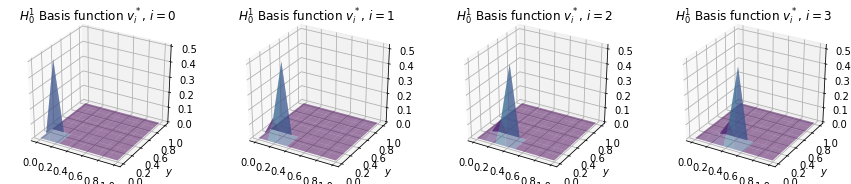

In [6]:
# We use the same parameters and Phi as in the last section.
L_H1 = np.linalg.cholesky(Phi_H1)

# Ok - this was only found experimentally....
# We need an UPPER triangular matrix for the dtrtri() routine *I think*, so it wasn't inversing this properly before
# when I wasn't taking the transpose. SO, now it inverses correctly, and this gives us something that works.
L_H1_inv = scipy.linalg.lapack.dtrtri(L_H1.T)[0]

Vstar_n_H1 = []
for i in range(n):
    Vstar_n_H1.append(hil.Vector(values=L_H1_inv[:,i], space=H1_coarse))

print('First few dot products\n( i , j )\t <V*i,V*j>_H1')
for i in range(3):
    for j in range(3):
        print(f'({i}, {j})\t {Vstar_n_H1[i].dot(Vstar_n_H1[j]):0.4e}')

show = 4

fig = plt.figure(figsize=(15, 3))
for i, vec in enumerate(Vstar_n_H1[:show]):
    ax = fig.add_subplot(1, show, i+1, projection='3d')
    Vstar_n_H1[i].plot(ax, title='$H^1_0$ Basis function $v^*_i$, $i={0}$'.format(i))
plt.show()

## Now I've abstracted this code in to a _Basis_ class, here we test it

Total difference between orthonormalised basis, manual vs class method in H1
Ortho vec 0: 0.18270644808612369
Ortho vec 1: 0.19349977935400064
Ortho vec 2: 0.2006212476280918
Ortho vec 3: 0.2016947081260638
Ortho vec 4: 0.20181452473039413
Ortho vec 5: 0.20182623855921614
Ortho vec 6: 0.2018273035899657
Ortho vec 7: 0.21240302214721724


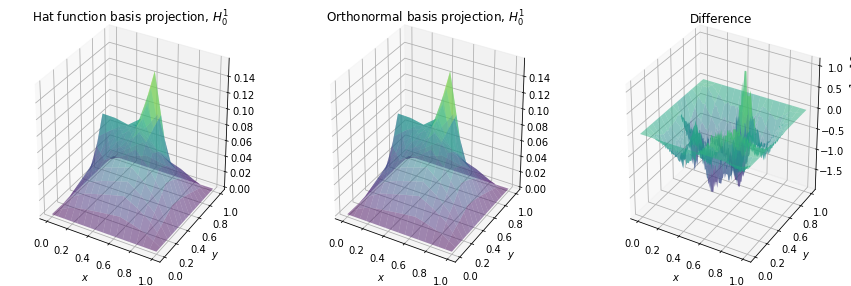

In [7]:
Vn_fine = [H1_fine.interp(v) for v in V_n]
hat_basis_H1 = hil.Basis(Vn_fine, space=H1_fine)

# Doing an orthogonal projection is as simple as...
u_p_H1 = hat_basis_H1.project(fem_solver.u)

# Similarly, orthonormalising is as simple as...
ortho_hat_basis_H1 = hat_basis_H1.orthonormalise()

# Compare the orthonormal basis to the previous results:
print('Total difference between orthonormalised basis, manual vs class method in H1')
for i in range(8):
    print(f'Ortho vec {i}: {(Vstar_n_H1[i] - ortho_hat_basis_H1[i]).norm()}')

# Make sure our orthonormal projection is the same as the original basis projection:
%matplotlib inline
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(1, 3, 1, projection='3d')
u_p_H1.plot(ax, title='Hat function basis projection, $H^1_0$')

ax = fig.add_subplot(1, 3, 2, projection='3d')
ortho_hat_basis_H1.project(fem_solver.u).plot(ax, title='Orthonormal basis projection, $H^1_0$')

ax = fig.add_subplot(1, 3, 3, projection='3d')
(u_p_H1 - ortho_hat_basis_H1.project(fem_solver.u)).plot(ax, title='Difference')

plt.show()


The difference plots are of the order of $10^{-16}$, i.e. machine precision (multiplier is missing from the axis for some reason...)

### Now lets look at the sinusoid basis and see how well it approximates our solutions...

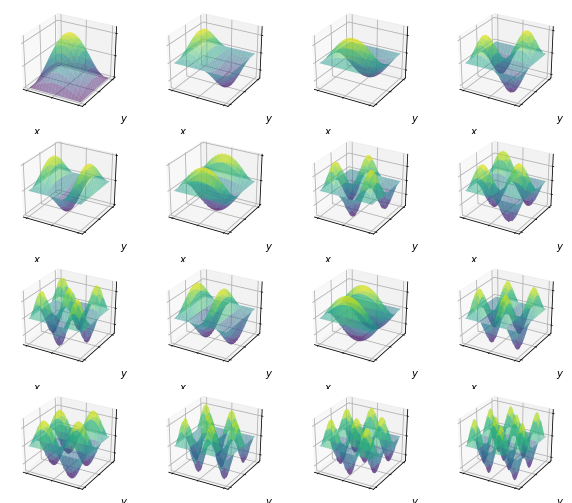

maximum difference between hat and sin projection: 0.02379825730941071


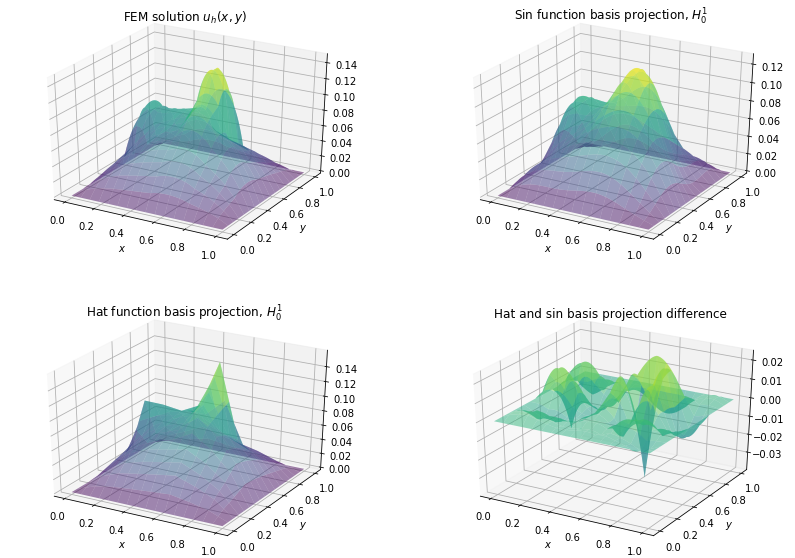

In [8]:
N = 4
sin_basis = rm.make_sin_basis(H1_fine.div, N=N)
hat_basis = H1_fine.interp(hil.Basis.space_rep_basis(H1_coarse))

sin_ortho_basis = sin_basis.orthonormalise()
hat_ortho_basis = hat_basis.orthonormalise()

fig = plt.figure(figsize=(10, 9))
for i, vec in enumerate(sin_ortho_basis):
    ax = fig.add_subplot(N, N, i+1, projection='3d')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    sin_ortho_basis[i].plot(ax)
plt.show()

u_sin = sin_ortho_basis.project(fem_solver.u)
u_hat = hat_ortho_basis.project(fem_solver.u)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(2, 2, 1, projection='3d')
fem_solver.u.plot(ax, title='FEM solution $u_h(x,y)$')

ax = fig.add_subplot(2, 2, 2, projection='3d')
u_sin.plot(ax, title='Sin function basis projection, $H^1_0$')
ax = fig.add_subplot(2, 2, 3, projection='3d')
u_hat.plot(ax, title='Hat function basis projection, $H^1_0$')
ax = fig.add_subplot(2, 2, 4, projection='3d')
(u_sin - u_hat).plot(ax, title='Hat and sin basis projection difference')

print('maximum difference between hat and sin projection:', (u_sin - u_hat).values.max())